In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import interpolate, signal

%matplotlib inline

In [2]:
# some functions used here
def pcoord(x, y):
    """
    Convert x, y to polar coordinates r, az (geographic convention)
    r,az = pcoord(x, y)
    """
    r  = np.sqrt( x**2 + y**2 )
    az = np.degrees( np.arctan2(x, y) )
    # az[where(az<0.)[0]] += 360.
    az = (az+360.)%360.
    return r, az

def xycoord(r, az):
    """
    Convert r, az [degrees, geographic convention] to rectangular coordinates
    x,y = xycoord(r, az)
    """
    x = r * np.sin(np.radians(az))
    y = r * np.cos(np.radians(az))
    return x, y

def buildGrid(xp,yp,alp,dx,dy,mxc,myc):
    '''
    X, Y = buildGrid(xp,yp,alp,dx,dy,mxc,myc) builds a rectangular grid
    
    Input :
        xp: x grid origin
        yp: y grid origin
        alp: degrees rotation of x-axis
        dx: x-direction grid spacing
        dy: y-direction grid spacing
        mxc: number of meshes in x-direction
        myc: number of meshes in y-direction
        
    Based on the Matlab function of Dave Thompson
    '''
    xlen = (mxc-1)*dx
    ylen = (myc-1)*dy
    
    x = np.arange(xp,xp+xlen+dx,dx)
    y = np.arange(yp,yp+ylen+dy,dy)

    X,Y = np.meshgrid(x,y);
    X = X-xp
    Y = Y-yp

    if alp != 0.:
       r,az = pcoord(X,Y)
       X,Y = xycoord(r,az+alp)
        
    X = X+xp
    Y = Y+yp
    print("Shape of X and Y: ",np.shape(X),np.shape(Y))

    return X, Y

In [3]:
# data directory
ddir = r"D:/crs/proj/2015_Sandwich/CCBay_Modeling/"

In [4]:
# load the coarse shoreline
s = np.genfromtxt(ddir+'shoreline.txt', delimiter=',')

In [15]:
%%time
# import the really big file of points
p = np.genfromtxt('all_points_xyz.txt', delimiter=',')

Wall time: 4min 44s


In [6]:
# spacing for the three grids
dxyf = 5.
dxym = 35.
dxyc = 245.
# angle of north end

In [7]:
alp = 130.

# make the coarse box
# direction to origin of coarse grid...same angle for base line, even
# increment of dxc
# back calculate location of lower left corner from upper left corner
LMc = 192.
MMc = 68.
xul = 366490.
yul = 4652500.
dxo,dyo = xycoord( (MMc-1)*dxyc, alp+90)
xpc = xul+dxo
ypc = yul+dyo

xlenc = (LMc-1)*dxyc
ylenc = (MMc-1)*dxyc

# box corners
bc = np.empty((4,2),float)
bc[0,:]=[xpc,ypc]
dxb, dyb = xycoord( xlenc, alp );
bc[1,:] = bc[0,:]+[dxb, dyb];
dxb, dyb = xycoord( ylenc, alp-90);
bc[2,:] = bc[1,:]+[dxb, dyb];
dxb, dyb = xycoord( xlenc, alp+180);
bc[3,:] = bc[2,:]+[dxb, dyb]

# make the coarse grid
dxc = dxyc;
dyc = dxyc;
print('Coarse grid is {} x {}, total = {}\n'.format(LMc,MMc,LMc*MMc))
xlenc = LMc*dxc
ylenc = MMc*dyc
X,Y = buildGrid( 0., 0., alp-90., dxc, dyc, LMc, MMc );
X = X + xpc
Y = Y + ypc

Coarse grid is 191.0 x 67.0, total = 12797.0

Shape of X and Y:  (68, 192) (68, 192)


In [8]:
# box corners should be the same as the corner points in X and Y
print(bc)

print(X[0,0],Y[0,0])
print(X[-1,0],Y[-1,0])

[[  355938.641387    4639925.3804662 ]
 [  391785.69110275  4609846.13427092]
 [  402337.04971575  4622420.75380472]
 [  366490.          4652500.        ]]
355938.641387 4639925.38047
366490.0 4652500.0


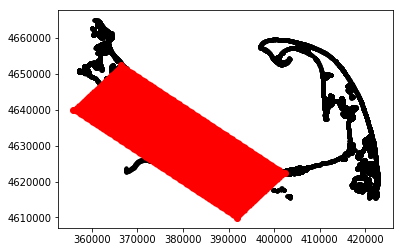

In [24]:
plt.plot(s[:,0],s[:,1],'.k')
plt.plot(bc[:,0],bc[:,1],'or')
plt.plot(bc[:,0],bc[:,1],'-r')
plt.plot([bc[0,0], bc[3,0]],[bc[0,1], bc[3,1]],'-r')
plt.plot(X,Y,'.r');

In [48]:
print("Shape of point array: ",p.shape)
shp = X.shape
print("Shape of grid arrays X and Y:",shp)
print(np.shape(np.array((np.ravel(X), np.ravel(Y))).T))
print(np.shape(p[:,0:2]))
print(np.shape(p[:,2]))

Shape of point array:  (64528617, 3)
Shape of grid arrays X and Y: (68, 192)
(13056, 2)
(64528617, 2)
(64528617,)


In [49]:
%%time
# interpolate data on to coarse grid
z= interpolate.griddata( p[:,0:2], p[:,2], np.array((np.ravel(X), np.ravel(Y))).T, method='linear', fill_value=np.NaN, rescale=False)

Wall time: 36min 46s


In [54]:
%%time
# interpolate data on to coarse grid
zn= interpolate.griddata( p[:,0:2], p[:,2], np.array((np.ravel(X), np.ravel(Y))).T, method='nearest', fill_value=np.NaN, rescale=False)

Wall time: 14min 58s


In [52]:
print(np.shape((X, Y)))
print(np.shape(X))

(2, 68, 192)
(68, 192)


In [53]:
shp = X.shape
print(np.ravel(X).shape)
print(np.squeeze(p[:,0:1]).shape)
print(np.squeeze(p[:,2]).shape)
print(np.min(p[:,0]),np.min(p[:,1]),np.min(p[:,2]))
print(np.max(p[:,0]),np.max(p[:,1]),np.max(p[:,2]))

print(z.shape)
z

(13056,)
(64528617,)
(64528617,)
355257.31 4615475.15 -201.09
437397.31 4664985.15 119.67
(13056,)


array([        nan,         nan,         nan, ...,  3.14250644,
        9.79248571,  4.60124504])

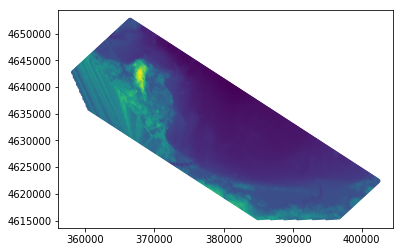

In [51]:
plt.scatter(np.ravel(X),np.ravel(Y),16,z)

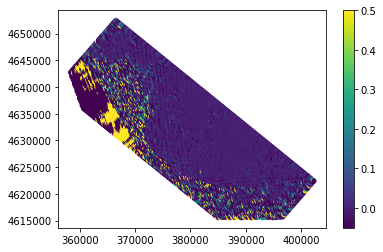

In [60]:
plt.scatter(np.ravel(X),np.ravel(Y),16,z-zn, vmin=-.05, vmax=.5)
plt.colorbar()

In [46]:
print(np.shape(points))
print(np.shape(values))

(1000, 2)
(1000,)
